In [3]:
import numpy as np
import pandas as pd
from brokenaxes import brokenaxes
from sklearn import preprocessing

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)

import matplotlib.pyplot as plt
import matplotlib
plt.rc('figure', figsize=(10,6))
plt.rc('font', **font)
np.set_printoptions(precision=4, suppress=True)



In [4]:
case_namelist = ['pfclm1_base1','pfclm1_base40',
                 'pfclm2_base1','pfclm2_base40']

time_length=336

# Reading the data

In [5]:
### define path
sfpath = '/home/chaochen/payette/chaochen/CZO/Chao/Demonstration_example/landlab_Const.Saprolite/postprocessing/waterbalance_cal/csv'

### load precipitation, in unit of mm/s
clm_input_path= '/home/chaochen/payette/chaochen/CZO/Chao/Demonstration_example/landlab_Const.Saprolite/clm_input'
clm_input='narr_1hr_new_extended.txt'
file = np.loadtxt('%s/%s' %(clm_input_path,clm_input)) 
precip_mms=file[:,2] 
precip_mh=precip_mms*3600/1000



### load surface storage, in unit of cubic meters
Datum_SS= pd.DataFrame(index=np.arange(0,time_length, 1), columns=case_namelist)
Datum_SubS= pd.DataFrame(index=np.arange(0,time_length, 1), columns=case_namelist)
Datum_SR= pd.DataFrame(index=np.arange(0,time_length, 1), columns=case_namelist)
Datum_WBD= pd.DataFrame(index=np.arange(0,time_length, 1), columns=case_namelist)
Datum_WBD_expetc= pd.DataFrame(index=np.arange(0,time_length, 1), columns=case_namelist)

#### read surface storage (SS)
for case_index in case_namelist:
    file_name_index= ('total_surface_storage_%s.csv' %(case_index))
    Datum_SS[case_index]= pd.read_csv('%s/%s' %(sfpath,file_name_index)).iloc[:,1]
print (Datum_SS)

#### read subsurafce storage (SubS)
for case_index in case_namelist:
    file_name_index= ('total_subsurface_storage_%s.csv' %(case_index))
    Datum_SubS[case_index]= pd.read_csv('%s/%s' %(sfpath,file_name_index)).iloc[:,1]
print (Datum_SubS)

#### read surface runoff (SR)
for case_index in case_namelist:
    file_name_index= ('total_surface_runoff_%s.csv' %(case_index))
    Datum_SR[case_index]= pd.read_csv('%s/%s' %(sfpath,file_name_index)).iloc[:,1]
print (Datum_SR)


#### read water balance diff (WBD)
for case_index in case_namelist:
    file_name_index= ('water_balance_diff_%s.csv' %(case_index))
    Datum_WBD[case_index]= pd.read_csv('%s/%s' %(sfpath,file_name_index)).iloc[:,1]
print (Datum_WBD)


#### read water balance diff expected (WBD_expetc)
for case_index in case_namelist:
    file_name_index= ('expected_difference_%s.csv' %(case_index))
    Datum_WBD_expetc[case_index]= pd.read_csv('%s/%s' %(sfpath,file_name_index)).iloc[:,1]
print (Datum_WBD_expetc)
### load ET, in depth
# Datum_ET= pd.DataFrame(index=np.arange(0,time_length, 1), columns=case_namelist)

# sfpath = '/home/chaochen/payette/chaochen/CZO/Chao/Demonstration_example/landlab_Const.Saprolite/postprocessing/ET_cal'
# for case_index in case_namelist:
#     file_name_index= ('total_subsurface_storage_%s.csv' %(case_index))
#     Datum_ET[case_index]= pd.read_csv('%s/%s' %(sfpath,file_name_index)).iloc[:,1]
# print (Datum_ET)


     pfclm1_base1  pfclm1_base40  pfclm2_base1  pfclm2_base40
0        0.000000       0.000000      0.000000     159.261218
1        0.000000      93.250264      0.000000    1595.578021
2        0.000000     330.245212      2.942517    4105.078847
3        0.000000     698.348968     12.871653    7818.854949
4        4.358812    1027.480463     38.648687   11262.752876
..            ...            ...           ...            ...
331   5957.701602    6294.757925  11650.847352   17934.345776
332   5946.341501    6294.992559  11643.349890   17930.360375
333   5937.301947    6295.470721  11635.970741   17927.009416
334   5933.366226    6297.444352  11629.428659   17924.920527
335   5931.598593    6299.404478  11623.062427   17922.786589

[336 rows x 4 columns]
     pfclm1_base1  pfclm1_base40  pfclm2_base1  pfclm2_base40
0    5.381003e+08   5.284993e+08  4.905221e+08   5.299796e+08
1    5.379381e+08   5.283956e+08  4.903222e+08   5.304312e+08
2    5.378165e+08   5.282723e+08  4.901861e+08

In [6]:
plt.plot(-Datum_ET)

NameError: name 'Datum_ET' is not defined

# Functions (remove the outliers)

In [7]:
# # funtion of removing the outliers, actually just wanna remove those with extream values
# def remove_outlier(df_in):
#     q1 = df_in.quantile(0.008)
#     q3 = df_in.quantile(0.992)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_out = df_in[(df_in > fence_low) & (df_in < fence_high)]
#     return df_out

In [8]:
# function of smooth the data, removin thing peaks and abrupt changes
def series_smooth(df_in):
    temp_result=df_in.copy()
    for i in range(len(df_in)):
        if i==0 or i==699:
            temp_result[i]=df_in[i]
        else:
            if (temp_result[i-1]-df_in[i])/temp_result[i-1]>0.1 or (temp_result[i-1]-df_in[i])/temp_result[i-1]<-0.1:
                temp_result[i]= (temp_result[i-1]+df_in[i+1])/2  
            else:
                temp_result[i]=df_in[i]
    return temp_result


# Computation, applying functions

### Computation, clean the data apply the functions (note: array may work better, for let it be for now)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


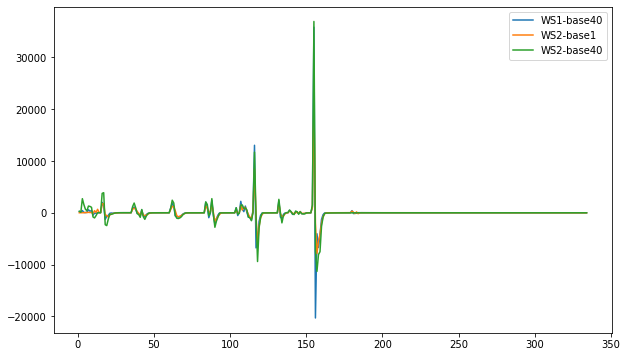

In [9]:
# plt.plot(Datum_SS.iloc[0:time_length,[1,2,3]])
# plt.plot(Datum_SubS.iloc[0:time_length,[1,2,3]])
plt.plot(Datum_SR.iloc[0:time_length,[1,2,3]].diff())
# -Datum_SR.iloc[0:time_length,:])
# plt.ylim(-1000,20000)
# plt.legend(["WS1-base1","WS1-base40","WS2-base1","WS2-base40"])
plt.legend(["WS1-base40","WS2-base1","WS2-base40"])

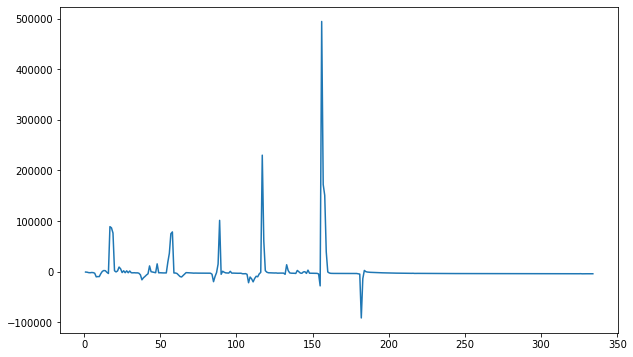

In [10]:
# plt.plot(precip_mh*198*198*30*30)
# plt.plot(Datum_SR.iloc[:,1])
# plt.plot(Datum_SS.iloc[:,1].diff())
# plt.plot(Datum_SubS.iloc[:,1].diff()/1000)

# plt.plot(precip_mh*198*198*30*30-Datum_SR.iloc[:,1])
# plt.plot(precip_mh*198*198*30*30-Datum_SR.iloc[:,1]-Datum_SS.iloc[:,1].diff())
plt.plot(precip_mh*198*198*30*30-Datum_SR.iloc[:,1]-Datum_SS.iloc[:,1].diff()-Datum_SubS.iloc[:,1].diff()/1000)
#          +df_sapro_final.iloc[5:,1].diff(),label='precp-surface runoff+saprolite storage change')


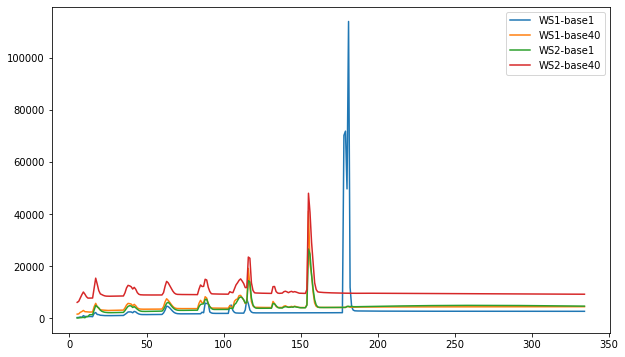

In [11]:
plt.plot(Datum_SR.iloc[5:time_length,:])
plt.legend(["WS1-base1","WS1-base40","WS2-base1","WS2-base40"])
# plt.ylim(0,10)

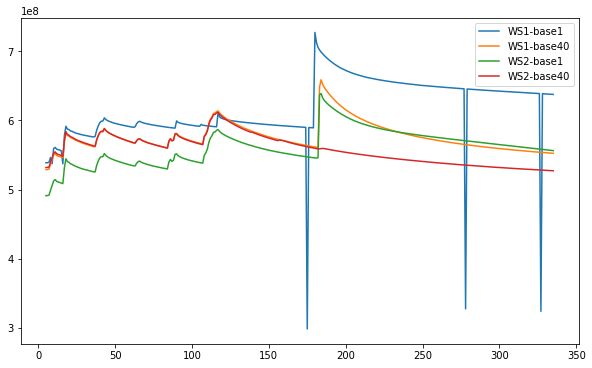

In [13]:
plt.plot(Datum_SubS.iloc[5:time_length,:])
plt.legend(["WS1-base1","WS1-base40","WS2-base1","WS2-base40"])

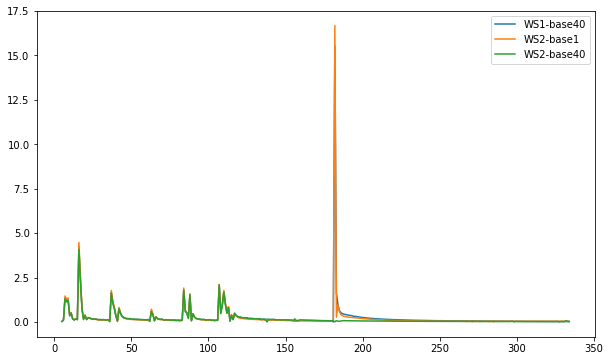

In [27]:
plt.plot(Datum_WBD.iloc[5:time_length,[1,2,3]])
plt.legend(["WS1-base40","WS2-base1","WS2-base40"])
# plt.ylim(0,10)

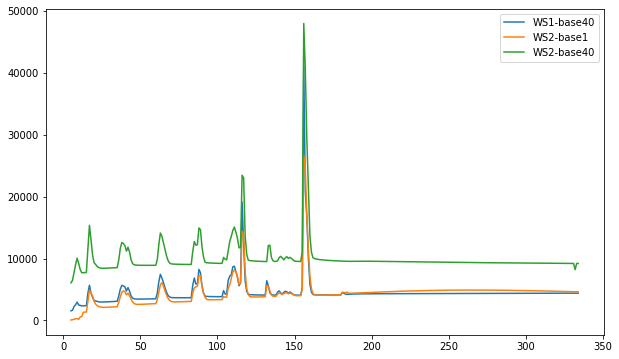

In [28]:
plt.plot(Datum_WBD_expetc.iloc[5:time_length,[1,2,3]])
plt.legend(["WS1-base40","WS2-base1","WS2-base40"])
# plt.ylim(0,10)

## Plot

### plot, water storage between case 1 and case 40, and in soil and saprolite

<function matplotlib.pyplot.close(fig=None)>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


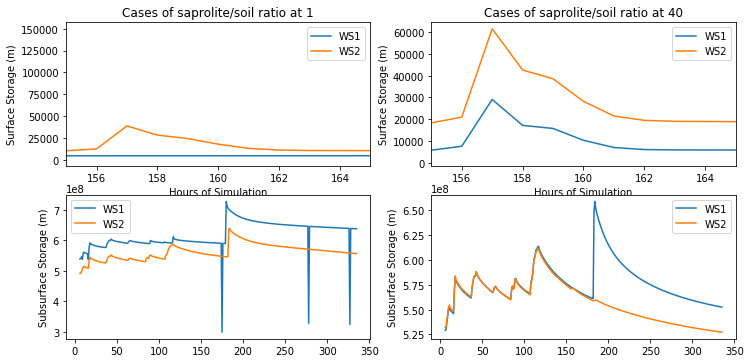

In [16]:
###### for component water volumn plots, volumn in soil and saprolite
fig = plt.figure(figsize=(12,9))

# plot, soil
soil_1510=fig.add_subplot(3, 2, 1)
plt.plot(Datum_SS.iloc[6:, [0,2]])
plt.ylabel("Surface Storage (m)")                      
plt.xlabel("Hours of Simulation")  
plt.legend(["WS1","WS2"])
plt.xlim(155,165)


soil_2040=fig.add_subplot(3, 2, 2)
plt.plot(Datum_SS.iloc[6:, [1,3]])
plt.ylabel("Surface Storage (m)")                      
plt.xlabel("Hours of Simulation")  
plt.legend(["WS1","WS2"])
plt.xlim(155,165)

fig.add_subplot(3, 2, 3)

plt.plot(Datum_SubS.iloc[6:,[0,2]])
plt.legend(["WS1","WS2"])

# plt.ylim(0.13,0.20)
plt.ylabel("Subsurface Storage (m)")
soil_1510.set_title("Cases of saprolite/soil ratio at 1")
plt.legend(["WS1","WS2"])

fig.add_subplot(3, 2, 4)
plt.plot(Datum_SubS.iloc[6:,[1,3]])
# plt.ylim(0.12,0.165)
# plt.xlabel("Days of Simulation")
plt.ylabel("Subsurface Storage (m)")
soil_2040.set_title("Cases of saprolite/soil ratio at 40")
plt.legend(["WS1","WS2"])


# # plot, saprolite
# fig.add_subplot(3, 2, 5)
# plt.plot(df_sapro_final.iloc[6:,[0,2]])
# plt.ylabel("Saprolite Storage (m)")
# plt.xlabel("Hours of Simulation")
# plt.legend(["WS1","WS2"])

# fig.add_subplot(3, 2, 6)
# plt.plot(df_sapro_final.iloc[6:,[1,3]])
# plt.ylabel("Saprolite Storage (m)")
# plt.xlabel("Hours of Simulation")
# plt.legend(["WS1","WS2"])
# # plt.ylim(3.7,3.75)
# # plt.ylim(3.875,3.92)
# plt.savefig('WaterContentComparisons_PFCLM.png')
# # plt.show()


plt.close


### plot the water storage in precipitation, surface water, soil water, and saprolite water

In [ ]:
###### plot the sum of soil and sparolite water storage
## plot the precipitation
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(3,1, 1)
# data conversion, from meter per second to meter per hour
precip_mmh=precip_mms*3600/1000
plt.plot(precip_mmh,'*-',label='Precipitation')
plt.ylabel("Precipitation (m)")

a1x=ax.twinx()
plt.plot(precip_mmh.cumsum() ,label='Accumulative Precipitation (m)')
plt.ylabel("Accumulative Precipitation (m)")
plt.legend(loc='upper left')


## plot the surface storage, in unit of m
cx = fig.add_subplot(3,1, 2)
# concert the unit from cubic meters into meter
# Datum_SS_m=Datum_SS/(198*198*5*5)
Datum_SS_m=Datum_SS # it's already converted into depth

plt.plot(Datum_SS.iloc[:, 0], label='pfclm1_base1')
plt.plot(Datum_SS.iloc[:, 1], label='pfclm1_base40')
plt.plot(Datum_SS.iloc[:, 2], label='pfclm2_base1')
plt.plot(Datum_SS.iloc[:, 3], label='pfclm2_base40')
plt.ylabel("Surface Water Storage (m)")
# plt.ylim(0,0.0025)
plt.legend(loc='upper left')

## plot the sub-surface storage, in unit of m
bx = fig.add_subplot(3,1, 3)
plt.plot(Datum_SubS.iloc[5:,0],'b+-',label='WS1-diffusive watershed, Saprolite/Soil =1')
plt.plot(Datum_SubS.iloc[5:,2], 'g+-',label='WS2-fluvial watershed, Saprolite/Soil =1')
plt.ylabel("Total Sub-surface Storage: \n Saprolite/Soil at 1 (m)")
# plt.ylim(0.185,0.4)
plt.legend(loc='upper left')

b1x=bx.twinx()
# plot
plt.plot(Datum_SubS.iloc[5:,1],'b',label='WS1-diffusive watershed, Saprolite/Soil =40')
plt.plot(Datum_SubS.iloc[5:,3],'g',label='WS2-fluvial watershed, Saprolite/Soil =40')
plt.ylabel("Total Sub-surface Storage: \n Saprolite/Soil at 40 (m)")
plt.xlabel("Days of Simulation")
# plt.ylim(3.65,4.2)
plt.legend(loc='upper right')

plt.savefig('totalWaterStorage_PFCLM.png')
plt.show()
plt.close

In [ ]:
## plot differential changes at each time step


fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(4,1, 1)

plt.plot(precip_mmh,'*-',label='Precipitation')
plt.xlim(5,time_length)
plt.ylabel("Precipitation (m)")


a1x=ax.twinx()
plt.plot(precip_mmh.cumsum() ,label='Accumulative Precipitation (m)')
plt.ylabel("Accumulative Precipitation (m)")
plt.legend(loc='upper left')
plt.xlim(5,time_length)

aa = fig.add_subplot(4,1, 2)
plt.plot(Datum_SS_m.iloc[:,0].diff(),label='WS1-B1')
plt.plot(Datum_SS_m.iloc[:,1].diff(),label='WS1-B40')
plt.plot(Datum_SS_m.iloc[:,2].diff(),label='WS2-B1')
plt.plot(Datum_SS_m.iloc[:,3].diff(),label='WS2-B40')
plt.ylabel("Cumulative differences at each time step \n- Surface Water component")
plt.xlim(5,time_length)
plt.legend()

bb = fig.add_subplot(4,1,3)
plt.plot(df_soil_final.iloc[5:,0].diff(),label='WS1-B1')
plt.plot(df_soil_final.iloc[5:,1].diff(),label='WS1-B40')
plt.plot(df_soil_final.iloc[5:,2].diff(),label='WS2-B1')
plt.plot(df_soil_final.iloc[5:,3].diff(),label='WS2-B40')
plt.ylabel("Cumulative differences at each time step \n- Soil water")
plt.xlim(5,time_length)
plt.legend()

cc = fig.add_subplot(4,1,4)
plt.plot(df_sapro_final.iloc[5:,0].diff(),label='WS1-B1')
plt.plot(df_sapro_final.iloc[5:,1].diff(),label='WS1-B40')
plt.plot(df_sapro_final.iloc[5:,2].diff(),label='WS2-B1')
plt.plot(df_sapro_final.iloc[5:,3].diff(),label='WS2-B40')
plt.plot(df_sapro_final.iloc[5:,3]*0, color='b')
plt.ylabel("Cumulative differences at each time step \n- Saprolite water")
plt.xlim(5,time_length)
plt.legend()

In [ ]:
# sum of all the water componets
fig = plt.figure(figsize=(15, 15))
plt.plot(Datum_SS_m.iloc[5:,0].diff()+df_soil_final.iloc[5:,0].diff()+df_sapro_final.iloc[5:,0].diff()-precip_mmh[5:time_length,],label='WS1-B1')
plt.plot(Datum_SS_m.iloc[5:,1].diff()+df_soil_final.iloc[5:,1].diff()+df_sapro_final.iloc[5:,1].diff()-precip_mmh[5:time_length,],label='WS1-B40')
plt.plot(Datum_SS_m.iloc[5:,2].diff()+df_soil_final.iloc[5:,2].diff()+df_sapro_final.iloc[5:,2].diff()-precip_mmh[5:time_length,],label='WS2-B1')
plt.plot(Datum_SS_m.iloc[5:,3].diff()+df_soil_final.iloc[5:,3].diff()+df_sapro_final.iloc[5:,3].diff()-precip_mmh[5:time_length,],label='WS2-B40')
plt.plot(df_sapro_final.iloc[5:,3]*0, color='b')
plt.ylabel("")
plt.legend()

In [ ]:
# sum of all the water componets
fig = plt.figure(figsize=(15, 15))
plt.plot(Datum_SS.iloc[5:,0].diff()+df_soil_final.iloc[5:,0].diff()+df_sapro_final.iloc[5:,0].diff()-precip_mmh[5:time_length,]+Datum_ET.iloc[5:,0],label='WS1-B1')
plt.plot(Datum_SS.iloc[5:,1].diff()+df_soil_final.iloc[5:,1].diff()+df_sapro_final.iloc[5:,1].diff()-precip_mmh[5:time_length,]+Datum_ET.iloc[5:,1],label='WS1-B40')
plt.plot(Datum_SS.iloc[5:,2].diff()+df_soil_final.iloc[5:,2].diff()+df_sapro_final.iloc[5:,2].diff()-precip_mmh[5:time_length,]+Datum_ET.iloc[5:,2],label='WS2-B1')
plt.plot(Datum_SS.iloc[5:,3].diff()+df_soil_final.iloc[5:,3].diff()+df_sapro_final.iloc[5:,3].diff()-precip_mmh[5:time_length,]+Datum_ET.iloc[5:,3],label='WS2-B40')
plt.plot(df_sapro_final.iloc[5:,3]*0, color='b')
plt.ylabel("")
plt.legend()

In [ ]:
# sum of all the water componets, except precipitation
fig = plt.figure(figsize=(15, 15))
plt.plot(Datum_SS_m.iloc[:,3].diff(), label='surface storage')
plt.plot(df_soil_final.iloc[:,3].diff(), label='soil storage')
plt.plot(df_sapro_final.iloc[:,3].diff(),label='saprolite storage')
plt.plot(precip_mmh,label='precipitaion')
# plt.plot(Datum_SS_m.iloc[:,0].diff()+df_soil_final.iloc[:,0].diff()+df_sapro_final.iloc[:,0].diff()-precip_mmh,label='WS1-B1')
# plt.plot(Datum_SS_m.iloc[:,1].diff()+df_soil_final.iloc[:,1].diff()+df_sapro_final.iloc[:,1].diff()-precip_mmh,label='WS1-B40')
# plt.plot(Datum_SS_m.iloc[:,2].diff()+df_soil_final.iloc[:,2].diff()+df_sapro_final.iloc[:,2].diff()-precip_mmh,label='WS2-B1')
# plt.plot(Datum_SS_m.iloc[:,3].diff()+df_soil_final.iloc[:,3].diff()+df_sapro_final.iloc[:,3].diff()-precip_mmh,label='WS2-B40')
plt.plot(df_sapro_final.iloc[5:,3]*0, color='b')
plt.xlim(6,time_length)
plt.ylim(-0.001,0.02)
plt.ylabel("")
plt.legend()

In [ ]:
## plot the ratio of each wate component, changing along the time
Datum_total=Datum_SS_m+df_water_total
ratio_sur=Datum_SS_m/Datum_total
ratio_soil=df_soil_final/Datum_total
ratio_sapro=df_sapro_final/Datum_total

fig = plt.figure(figsize=(10, 10))
bb = fig.add_subplot(3,1, 2)
plt.plot(ratio_soil.iloc[1:,0],label='WS1-B1')
plt.plot(ratio_soil.iloc[1:,1],label='WS1-B40')
plt.plot(ratio_soil.iloc[1:,2],label='WS2-B1')
plt.plot(ratio_soil.iloc[1:,3],label='WS2-B40')
plt.ylabel("Soil Water component")
plt.legend()

cc = fig.add_subplot(3,1, 3)
plt.plot(ratio_sapro.iloc[1:,0],label='WS1-B1')
plt.plot(ratio_sapro.iloc[1:,1],label='WS1-B40')
plt.plot(ratio_sapro.iloc[1:,2],label='WS2-B1')
plt.plot(ratio_sapro.iloc[1:,3],label='WS2-B40')
plt.ylabel("Soil Water component")
plt.legend()
plt.bar(normalized_X, height=1, label='WS1-B1')
plt.plot(ratio_sur.iloc[1:,1],label='WS1-B40')
plt.plot(ratio_sur.iloc[1:,2],label='WS2-B1')
plt.plot(ratio_sur.iloc[1:,3],label='WS2-B40')
plt.ylabel("Surface Water component")

# plt.plot(ratio_soil.iloc[:,0],label='soil water')
# plt.plot(ratio_sapro.iloc[:,0],label='saprolite water')
plt.legend()

bb = fig.add_subplot(3,1, 2)
plt.plot(ratio_soil.iloc[1:,0],label='WS1-B1')
plt.plot(ratio_soil.iloc[1:,1],label='WS1-B40')
plt.plot(ratio_soil.iloc[1:,2],label='WS2-B1')
plt.plot(ratio_soil.iloc[1:,3],label='WS2-B40')
plt.ylabel("Soil Water component")
plt.legend()

cc = fig.add_subplot(3,1, 3)
plt.plot(ratio_sapro.iloc[1:,0],label='WS1-B1')
plt.plot(ratio_sapro.iloc[1:,1],label='WS1-B40')
plt.plot(ratio_sapro.iloc[1:,2],label='WS2-B1')
plt.plot(ratio_sapro.iloc[1:,3],label='WS2-B40')
plt.ylabel("Soil Water component")
plt.legend()